# Assignment 06: K-Means and PCA

**Due Date:** Sunday 12/06/2024 (by midnight)

**Please fill these in before submitting, just in case I accidentally mix up file names while grading**:

Name: Aidan Corrales

CWID-5: 31600

## Introduction 

In this exercise, you will implement the K-means clustering algorithm and apply it to cluster a small set of data.
In the second part of the assignment, you
will implement the basics of principal component analysis to visualize the resulting principal component vectors found for some data, and see how such
data are projected onto the principal components.  

In [1]:
# The following ipython magic will reload changed file/modules.
# So when editing function in source code modules, you should
# be able to just rerun the cell, not restart the whole kernel.
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib

# By convention, we often just import the specific classes/functions
# from scikit-learn we will need to train a model and perform prediction.
# Here we include all of the classes and functions you should need for this
# assignment from the sklearn library, but there could be other methods you might
# want to try or would be useful to the way you approach the problem, so feel free
# to import others you might need or want to try
from sklearn.cluster import KMeans

In [3]:
# Import functions/moduls from this project.  We manually set the
# PYTHONPATH to append the location to search for this assignments
# functions to just ensure the imports are found
import sys
sys.path.append("../src")

# assignment function imports for doctests and github autograding
# these are required for assignment autograding
from assg_utils import run_unittests, run_doctests
from assg_tasks import task_1_1_load_data, find_closest_centroids, compute_centroids, kmeans_cluster, task_2_1_load_data, feature_normalize, pca, project_data, recover_data

In [4]:
# notebook wide settings to make plots more readable and visually better to understand
np.set_printoptions(suppress=True)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('figure', titlesize=18)
plt.rc('legend', fontsize=14)
plt.rcParams['figure.figsize'] = (12.0, 8.0) # default figure size if not specified in plot
plt.style.use('seaborn-v0_8-darkgrid')

# Task 1 K-means Clustering

In the first part of this exercise, you will implement the K-means algorithm by hand and use it to visualize an example of how
K-means clustering functions in practice. We will be using an example 2D dataset that will help you gain an intiution of how
the K-means algorithm works.  After implementing by hand, you will also cluster the data using
`scikit-learn`'s implementation.

## 1.1 Load K-means Test Dataset

First of all, as we have done in previous assingments, complete the following function to load the
task 1 data to be used.  The data is in the file named `../data/assg-06-data-kmeans.csv` for this
assignment.  The dataset contains two features we will be referring to as $x_1$ and $x_2$ 
in this assignment.  You are expected to load the data samples
in the function named `task_1_1_load_data()` and return them as a simple
`NumPy` array of shape `(300,2)` for this assignment.  Complete the function so that it passes
the tests for this task.

In [10]:
# do not remove or modify the code in this cell
X = task_1_1_load_data()
run_unittests(['test_task_1_1_load_data'])

test_X_properties (test_assg_tasks.test_task_1_1_load_data.test_X_properties)
test_X_properties ... 

ok
test_loaded_types (test_assg_tasks.test_task_1_1_load_data.test_loaded_types)
test_loaded_types ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.022s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

In the following cell(s), do some of the usual basic data exploration to familarize yourself
with the data.  You might find it helpful to create a Pandas `DataFrame` of the data
so that you can use Pandas tools to explore the data. Show the feature ranges and min, mean, max.  Determine if any values are missing.

In [13]:
# do some data exploration here for the dataset, is any data missing?  What is the range of the data?
x1 = X[:, 0]
x2 = X[:, 1]

print("\nFeature x1:")
print(f"Min: {x1.min():.4f}, Max: {x1.max():.4f}, Mean: {x1.mean():.4f}")

print("\nFeature x2:")
print(f"Min: {x2.min():.4f}, Max: {x2.max():.4f}, Mean: {x2.mean():.4f}")

print("\nAny missing values?")
print("x1:", np.isnan(x1).sum(), "missing")
print("x2:", np.isnan(x2).sum(), "missing")


Feature x1:
Min: -0.2451, Max: 8.2034, Mean: 3.6844

Feature x2:
Min: 0.2058, Max: 5.7843, Mean: 2.9871

Any missing values?
x1: 0 missing
x2: 0 missing


And finally visualize the unlabeled data in the next cell.  Use the `NumPy`
array named `centroids` in the visualization, these will be the initial
centroid positions we will use for testing.

The visualization should plot the data that you loaded, and also indicate the initial centroids that we will be using.
Use blue circles for the loaded data, and black Xs for the initial centroids that will be used.  Don't forget to 
label your figure and provide a legend. Try and recreate the following plot with your work:

![Task 1 data for k-means clustering](../figures/task_1_1_plot.png)

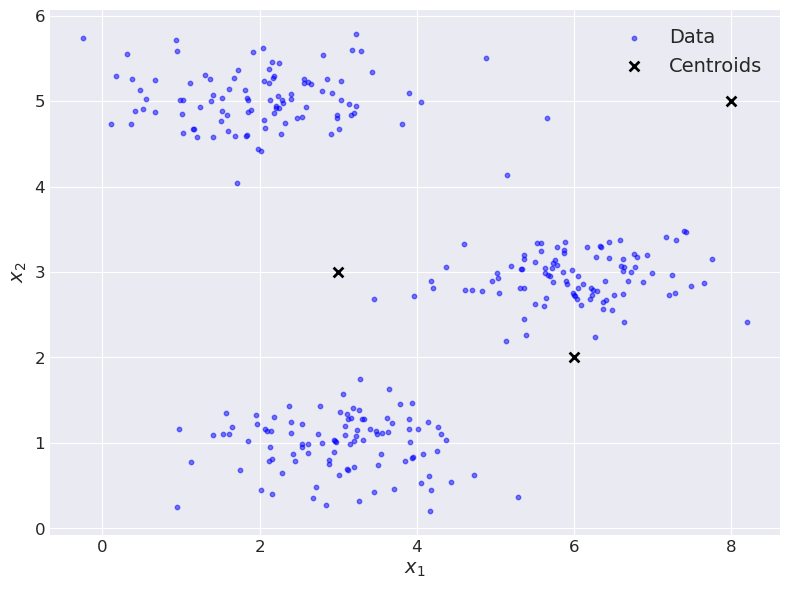

In [20]:
# visualize the dataset as well as the initial centroid positions you will use in developing k-means implementation
centroids = np.array([[3.0, 3.0],
                      [6.0, 2.0],
                      [8.0, 5.0]])

plt.figure(figsize=(8, 6))
plt.scatter(x1, x2, c='blue', marker='o', s=10, label='Data', alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='x', s=50, linewidths=2, label='Centroids')

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Implementing K-means

The K-means algorithm is a method to automatically cluster similar data examples together.  Concretely, you are given a training
set `X` $\{ x^{(1)}, x^{(2)}, \ldots, x^{(n)} \}$ (where $x^{(i)} \in \mathbb{R}^m$ is $m$ dimensional), and want to group the
data into a few cohesive "clusters".  The intuition behind K-means is an iterative procedure that starts by guessing the
initial centroids, and then refines this guess by repeatedly assigning examples to their closest centroids and then recomputing
the centroids based on the assignment.

In Python pseudo-code, the K-means algorithm is as follows:
```python
# Initialize centroids
centroids = "select K samples at random (without replacement) to be the initial centroids"

# iterate procedure to move centroids incrementally
for iter = range(number of iterations to perform): # or iterate until we detect convergence
   # Cluster assignment step: Assign each data point to the
   # closest centroid.  c[i] corresponds to the c^(i), the index of the
   # centroid assigned to example i
   c = find_closest_centroids(X, centroids)
   
   # Move centroid step: Compute means based on centroid assignments
   centroids = compute_centroids(X, c, K)
```

The main loop of the algorithm repeatedly carries out two steps: (i) Assigning each training example $x^{(i)}$ to its closest
centroid, and (ii) Recomputing the mean of each centroid using the points assigned to it.  The K-means algorithm will always
converge to some final set of means for the centroids.  Note that the converged solutions may not always be ideal and depends on
the initial selection of the centroids.  Therefore, in practice, the K-means algorithm is usually run a few times with different
random initializations.  One way to choose between these different solutions from different random initializations is to choose
the one with the lowest cost function value (distortion).

In this exercise you will implement the two phases of the K-means algorithm separately as functions with the names
`find_closest_centroids()` and `compute_centroids()`.

## 1.2 Finding Closest Centroids

In the "cluster assignment" phase of the K-means algorithm, the algorithm assigns every training example $x^{(i)}$ to its
closest centroid, given the current positions of centroids.  Specifically, for every example $i$ we set

$$
c^{(i)} := j \;\; \text{that minimizes} \;\; \| x^{(i)} - \mu_j \|^2
$$

where $c^{(i)}$ is the index of the centroid that is closest to $x^{(i)}$, and $\mu_j$ is the position (value) of the $j$'th
centroid.  In English, this means that you compute the distance between each sample and each of the k current centroid positions, and
we assign the sample to the centroid $j$ that it is currently closest to.

For this task, complete the code for the `find_closest_centroids()` function in the `src/assg_tasks.py` file, and pass the given tests for
this function.  This function takes the data matrix `X`
and the current locations of the `centroids` as input parameters.  It should output a one-dimensional array `c` that holds the
index (a value in $\{0, \cdots, K-1\}$, where $K$ is the total number of centroids) of the closest centroid to every
training example.

You can implement this using a loop over every training example and every centroid.  If you complete the function successfully,
it should pass the tests for this task that test it correctly finds the closest centroids for the dataset for a couple of
different initial centroids.

In [24]:
# do not remove or modify the code in this cell
c = find_closest_centroids(X, centroids)
run_unittests(['test_find_closest_centroids'])

test_assg_initial_centroids (test_assg_tasks.test_find_closest_centroids.test_assg_initial_centroids)
test_assg_initial_centroids ... ok


test_random_dataset (test_assg_tasks.test_find_closest_centroids.test_random_dataset)
test_random_dataset ... ok
test_two_centroids (test_assg_tasks.test_find_closest_centroids.test_two_centroids)
test_two_centroids ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.037s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

## 1.3 Computing Centroid Means

Given assignments of every point to a centroid (calculated by the `find_closest_centroids()` function you just wrote), the
second phase of the K-means algorithm recomputes, for each centroid, the mean of the points that were assigned to it.  Formally, for
every centroid $k$ we set

$$
\mu_k := \frac{1}{|C_k|} \sum_{i \in C_k} x^{(i)}
$$

where $C_k$ is the set of example input data that are assigned to centroid $k$ and $| C_k |$ is the number of items that were
thus assigned.  Concretely, if two examples say $x^{(3)}$ and $x^{(5)}$ are assigned to centroid $k = 2$, then $| C_k | = 2$
and you should update $\mu_2 = \frac{1}{2}(x^{(3)} + x^{(5)})$  The calculation of $\mu$ is really just finding the mean of all
samples that have been assigned to the given centroid.

You should now complete the code for the `compute_centroids()` function in the `assg_tasks.py` file.  The functions takes in the values `X` that are being clustered, and the centroid assignment index `c` of each
of the samples in `X`.  We also pass in `K`, the number of clusters  being calculated.

You can implement this function using a loop over the
centroids.   You can also use a loop over the examples, but for this function there is a fairly straight forward way to vectorice
much of the code (but either an iterative or vectorized solution is fine for this assignment).

Once you have completed the function, it should successfully pass the given tests for it, and you will now have the major pieces you need to successfully implement the K-means algorithms by hand.


In [25]:
# do not remove or modify the code in this cell
K = centroids.shape[0]
centroids = compute_centroids(X, c, K)
run_unittests(['test_compute_centroids'])

test_assg_initial_centroids (test_assg_tasks.test_compute_centroids.test_assg_initial_centroids)
test_assg_initial_centroids ... ok
test_random_dataset (test_assg_tasks.test_compute_centroids.test_random_dataset)
test_random_dataset ... ok
test_two_centroids (test_assg_tasks.test_compute_centroids.test_two_centroids)
test_two_centroids ... 

ok

----------------------------------------------------------------------
Ran 3 tests in 0.054s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

## 1.4 K-means Hand Built Solution

After completing the previous two functions to find the closest centroids and recompute centroid means from the samples in a class,
it will be relatively simple to implement a complete version of the K-means clustering algorithm by hand using the previous two
functions, which perform most of the work of the clustering algorithm.

For the next task complete the `kmeans_cluster()` function so that it successfully passes the tests for this task.  This function
takes the `X` unlabeled data that is to be clustered and labeled, and the meta-prameter `K` indicating the number of
clusters to find in the data.  There are two additional parameters that control the number of centroid update iterations that
are performed, and set up the random state to have reproducable results.

We do need to randomly create/select `K` random centroids (we don't pass in the initial centroid choices).  The normal way
this is done is to choose `K` samples at random from the `X` inputs being clustered to serve as the initial
centroid locations.  You should set the `NumPy` random seed using the `random_state` passed into this function.  And then
you are required to use the following method to randomly choose the initial centroids.  Call the `NumPy` `random.choice()`
method.  You can ask it to choose `K` indexes from the valid `0..n-1` sample indexes you have in the `X` inputs.  Make sure you
choose the indexes without replacement, so that the same sample is not used multiple times for the initial centroids.  
Given the indexes choosen, you should be able to then easily extract those samples to serve as the initial centroids that
will be itereated.

In the main loop of your function, you are required to reuse your `find_closest_centroids()` and `compute_centroids()`
functions.  In a real implementaton of the K-Means algorithm, we would test when the centroid labels remain the same from
one iteration to the next and stop at that point (indicating convergence), but for this implementation simply iterate the fixed number of cycles
specified by the `num_iter` parameter to the function (we will leave it as an exercise to the student to implement
stopping on convergence).

The function returns the cluster `labels` that were assigned by the K-means clustering.  Essentially the `c` indexes returned by
your `find_closest_centroids()` are the labels of each point to the category determined by the clustering.  In addition
a `history` of the iterated centroids should be returned, so that you can visualize the evolution of the cluster
centroids after the function is called.  This should just be a regular python `list`, and the item at index 0
should be the initially randomly selected centroids.  The list should have a length of `num_iter + 1` since it contains
the initial random centroids at index 0, and then the updated centroids after each iteration of the main loop.

Your implementation of the `kmeans_cluster()` should pass the given tests if your previous two functions are passing
and implemented as expected, and if you correctly set the random seed and choose the initial centroids as described.

In [26]:
# do not remove or modify the code in this cell
K = 3
labels, history = kmeans_cluster(X, K, num_iter=10)
run_unittests(['test_kmeans_cluster'])

test_assg_data (test_assg_tasks.test_kmeans_cluster.test_assg_data)
test_assg_data ... ok

----------------------------------------------------------------------
Ran 1 test in 0.056s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

Once your function is working, visuzlize the clusters that were found and the history of the
centroid updates.  You should be able to recreate the following figure pretty much as shown if
your implementation is passing tests for this task.  Use shape and color to indicate which
samples were assigned to which categories / labels.  Also display the evolution of each of the 3 centroids
that were found as shown using the `history` returned from your function.

![Task 1.4 k-means labels and centroid history](../figures/task_1_4_plot.png)

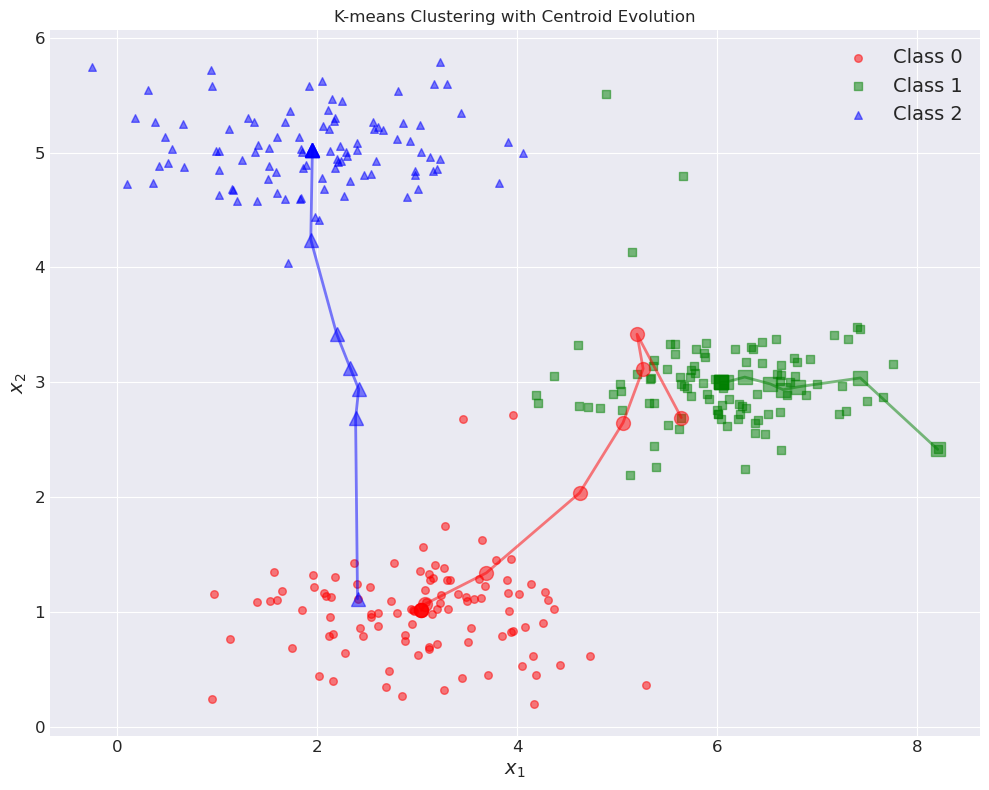

In [46]:
# reproduce plot of visualization of clusters and k-means history here

#I went way overboard trying to make the plot similar to the example...

plt.figure(figsize=(10, 8))

for k in range(K):
    cluster_points = X[labels == k]
    
    if k == 0:
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Class {k}', 
                    s=30, alpha=0.5, marker='o', color='r')
    
    elif k == 1:
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Class {k}', 
                    s=30, alpha=0.5, marker='s', color='g')
    
    else:
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Class {k}', 
                    s=30, alpha=0.5, marker='^', color='b')

centroid_path_1 = [history[i][0] for i in range(10 + 1)]
centroid_path_1 = np.array(centroid_path_1)
plt.plot(centroid_path_1[:, 0], centroid_path_1[:, 1], marker='o', markersize=10, linestyle='-', linewidth=2, color='r', alpha=0.5,)

centroid_path_2 = [history[i][1] for i in range(10 + 1)]
centroid_path_2 = np.array(centroid_path_2)
plt.plot(centroid_path_2[:, 0], centroid_path_2[:, 1], marker='s', markersize=10, linestyle='-', linewidth=2, color='g', alpha=0.5,)

centroid_path_3 = [history[i][2] for i in range(10 + 1)]
centroid_path_3 = np.array(centroid_path_3)
plt.plot(centroid_path_3[:, 0], centroid_path_3[:, 1], marker='^', markersize=10, linestyle='-', linewidth=2, color='b', alpha=0.5,)

plt.title('K-means Clustering with Centroid Evolution')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 1.5 Perform Standard Scikit Learn KMeans Clustering

Finally in the next cell, perform a `K=3` KMeans clustering using the `scikit-learn` libraries
implementation on this tasks data.  Access the fit estimator to report the final labels and the final centroids
that `scikit-learn` gets from clustering the data.  This data is relatively simple, so you should
find that basically the same 3 centroids will be reached as your hand implementation
for this data.

In [47]:
# cluster the data using scikit-learn and report the final labels and centroids obtained here
K = 3
kmeans = KMeans(n_clusters=K, random_state=42)
kmeans.fit(X)

labels_sklearn = kmeans.labels_
centroids_sklearn = kmeans.cluster_centers_

print("Final Centroids (from scikit-learn):")
print(centroids_sklearn)
print("\nFinal Labels (from scikit-learn):")
print(labels_sklearn)


Final Centroids (from scikit-learn):
[[3.04367119 1.01541041]
 [6.03366736 3.00052511]
 [1.95399466 5.02557006]]

Final Labels (from scikit-learn):
[2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2]


# 2 Principal Component Analysis

In this part of the exercise, you will implement the basics of principal component analysis (PCA) by and, and
use it to perform dimensionality reduction.   You will use
a small example 2D dataset to get an intuition on how PCA works.

## 2.1 Load PCA Test Dataset

To help you understand how PCA works, you will use the dataset given
in the file `../data/assg-06-data-pca.csv` for this task.  This
dataset again contains two features.  Complete the function named
`task_2_1_load_data()`.  The tests again expect you to create and
return a simple `NumPy` array which will be of shape `(50,2)` for
this data set.  Complete the function so that it passes the tests for
this task.

In [48]:
# do not remove or modify the code in this cell
X = task_2_1_load_data()
run_unittests(['test_task_2_1_load_data'])

test_X_properties (test_assg_tasks.test_task_2_1_load_data.test_X_properties)
test_X_properties ... ok
test_loaded_types (test_assg_tasks.test_task_2_1_load_data.test_loaded_types)
test_loaded_types ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.014s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

As with task 1, perform some basic data exploration
here.  You probably should create a Pandas
`DataFrame` of the data so that you can
determine the data mean, min max and range.
Make sure there are no missing values and that you get
the expected 50 samples with 2 features.

In [51]:
# do some data exploration here for the dataset, is any data missing?  What is the range of the data?
df = pd.DataFrame(X, columns=['Feature 1', 'Feature 2'])

print("Data Shape:", df.shape)
print("\nSummary Statistics:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())

feature_range = df.max() - df.min()
print("\nFeature Range:")
print(feature_range)

Data Shape: (50, 2)

Summary Statistics:
       Feature 1  Feature 2
count  50.000000  50.000000
mean    3.989265   5.002806
std     1.173050   1.023408
min     1.180233   2.878694
25%     3.051136   4.418211
50%     3.963505   5.012886
75%     4.891286   5.810504
max     5.911298   7.363197

Missing Values:
Feature 1    0
Feature 2    0
dtype: int64

Feature Range:
Feature 1    4.731065
Feature 2    4.484503
dtype: float64


And also as before, visualize the data.  We do not provide an example
of the figure this time as you simply need to plot the data we are using,
nothing else.  Make sure to label your axis as usual.

Note that the mean of feature $x_1$ is around 4 and of feature $x_2$
is around 5 for the raw data that you load.


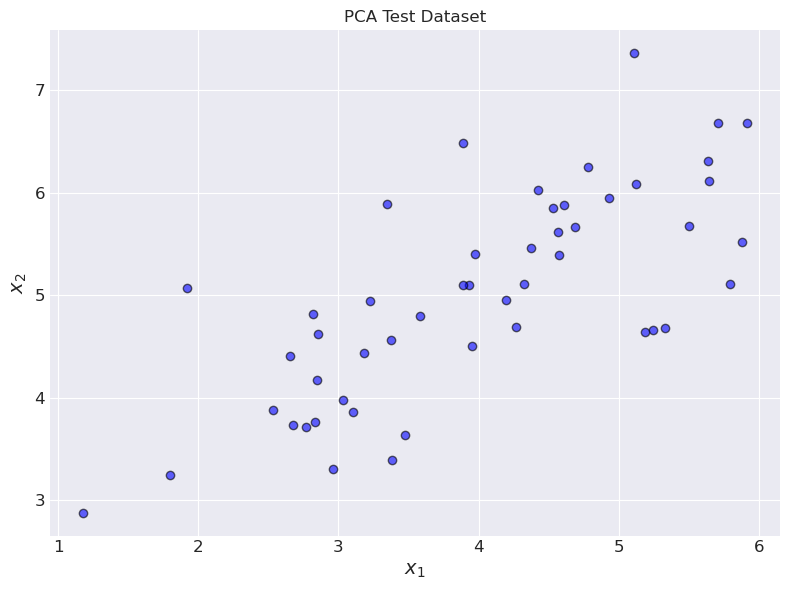

In [55]:
# visualize the task 2 data here to familiarize yourself with what it looks like
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], color='blue', alpha=0.6, edgecolors='k', marker='o')
plt.title('PCA Test Dataset')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.grid(True)
plt.tight_layout()
plt.show()

## 2.2 Feature Normalization and Scaling

Before using PCA, it is important to first normalize the data by subtracting the mean value of each feature from the feature
so that the features all have a mean of zero,
and scaling each dimension (by their variance) so that they all are in the same range nad have variances of 1.0.  

For this task, implement the function named `feature_normalize()` in the `src/assg_tasks.py` file.
You could use `scikit-learn` scaling functions to do this, but I am requiring you to instead perform
the feature normalization and scaling by hand for this function, using only basic `NumPy` operations.
Your function will take the unnormalized data samples `X` as input and return 3 results.
It returns an new array named `X_norm` that contains the normalized and scaled data.  It should also return
`NumPy` arrays `mu` and `sigma`.  This will contain the means (`mu`) and the variances
(`sigma`) of the original unnormalized and unscaled data.  We need this information to undo any
dimensionality reduction if we want to project it back onto the original dataspace before normalization
and scaling.

If your function is working correctly on the test data, it should pass the tests given for it
in this task.

In [56]:
# do not remove or modify the code in this cell
X_norm, mu, sigma = feature_normalize(X)
run_unittests(['test_feature_normalize'])

test_assg_data (test_assg_tasks.test_feature_normalize.test_assg_data)
test_assg_data ... ok
test_random_data (test_assg_tasks.test_feature_normalize.test_random_data)
test_random_data ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.016s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

## 2.3 Implement PCA using SVD by Hand

In this part of the exercise, you will implement PCA by hand.  PCA consists of two computational steps: First, you compute the 
covariance matrix of the data.  Then you use the `NumPy` `svd` singular value decomposition function from the linear algebra routines to compute the
eigenvectors $U_1, U_2, \cdots, U_n$.  These will correspond to the principal components of variation in the data.


You will first reuse your `feature_normalize()` function to get a normalized
and scaled version of the data.  After normalizing the data, you first have to
calculate the **covariance matrix** of the nromalized data, which is the actual
matrix we will pass to the singular value decomposition routine.

Formally, to compute the covariance matrix of the data, you need to perform the following:

$$
\Sigma = \frac{1}{m} X^T X
$$

where $X$ is the data (now nnormalized) matrix with samples in rows, and $m$ is the number of samples.  Note that $\Sigma$ should be a
$n \times n$ square matrix.  Also don't be confused by notation here, while $\Sigma$ means summation in some context, it is a simple
variable name here that you can think of as `S` if that is easier.  The covariance matrix is related to computing the similarity or
covariance between features, which is essentially what you do here.  You need to perform a matrix multiplication, and also don't forget
to divide by `m` to average out these values.

After computing the covariance matrix, you can run singular value decomposition (SVD) on `S` / $\Sigma$ to compute the principal components.  You can find an implementation
of the SVD singular value decomposition in Python's `numpy.linalg` library, and it will return the matrics `[U, S, V]` where
matrix `U` will contain the principal components we need and S will contain a diagonal matrix which holds information about the
amount of variance represented by each found principal component.

The `pca()` function takes the unnormalized data `X` to run the unsupervised learning algorithm on.  The function
returns the resulting `U` and `S` matrices from the SVD (we don't need the `V` in this assignment).  Also you need
to return the `mu` and the `sigma` settings obtained from normalizing and scaling the data from this function.

Complete the function named `pca()` in the `src/assg_tasks.py` file.  Once you have completed it, it should successfully
pass the given tests of your implemenation on the test data we are using.


In [57]:
# do not remove or modify the code in this cell
U, S, mu, sigma = pca(X)
run_unittests(['test_pca'])

test_assg_data (test_assg_tasks.test_pca.test_assg_data)
test_assg_data ... ok

----------------------------------------------------------------------
Ran 1 test in 0.012s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

To understand what the U vectors of principal components represent, it helps to plot them on our original data.  Each column of U
represents a vector.  Likewise each value of the S array represents the amount of variation that that principal component
vector explains or represents.  If we draw our two resulting vectors at the mean location of our data, and scale them by
the amount of variation given by S, we can see what principal component directions were discovered.  For example, lets replot our
data, then plot the U principal component vectors as we just described.  If your code is passing tests for `pca()`
then the following cell should now reproduce this figure:

![Task 2.3 Determined Principal Components for Task 2 Data](../figures/task_2_3_plot.png)

Original feature means:  [3.98926528 5.00280585]
First principal component vector:  [-0.70710678 -0.70710678]
Second principal component vector:  [-0.70710678  0.70710678]


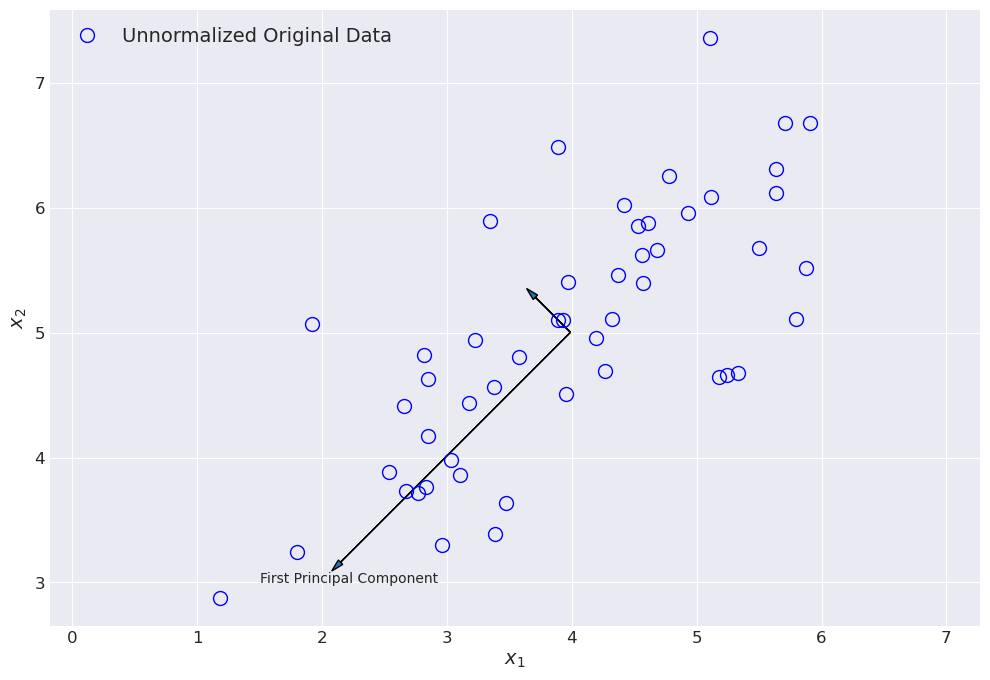

In [58]:
# plot the raw data again
plt.figure()
plt.plot(X[:, 0], X[:, 1], 'bo', markersize=10, fillstyle='none', label='Unnormalized Original Data')
plt.axis('equal')
ax = plt.gca()

# plot principal component 1.  u1 is a vector, we will plot this vector from the mu means of our data
u1 = U[:, 0]
print('Original feature means: ', mu)
print('First principal component vector: ', u1)
p1 = mu
v = u1 * 1.5 * S[0] # multiplying by S has effect of scaling this component by the magnitude of variance
ax.arrow(mu[0], mu[1], v[0], v[1], head_width=0.05, head_length=0.1)

# plot principal component 2.  u2 is a vector, we will plot this vector from the mu means of our data
u2 = U[:, 1]
print('Second principal component vector: ', u2)
p1 = mu
v = u2 * 1.5 * S[1] # multiplying by S has effect of scaling this component by the magnitude of variance
ax.arrow(mu[0], mu[1], v[0], v[1], head_width=0.05, head_length=0.1)
ax.text(1.5, 3, "First Principal Component")

# add in labels and legend
plt.xlabel(f'$x_1$')
plt.ylabel(f'$x_2$')
plt.legend();

In the previous figure, we have used the `U` principal components as vectors, and we have drawn representations of these vectors
originating from the mean location for each feature of our original data.  We have scaled the length we drew each vector by
the value given in S, in order to represent the magnitude of variation represented by each of the principal component directions
that were discovered.

## 2.4 Dimensionality Reduction with PCA

After computing the principal components, you can use them to reduce the feature dimension of your dataset by projecting each
example onto a lower dimensional space $x^{(i)} \rightarrow z^{(i)}$  (e.g., projecting the data from 2D to 1D).  In this part
of the exercise, you will use the eigenvectors returned by PCA and project the example dataset onto a 1-dimensional space.

In practice, if you were using a learning algorithm such as linear regression or perhaps neural networks, you could now use the
projected data instead of the original data.  By using the projected data, you can train your model faster as there are less
dimensions in the input.

For the following cell, complete the function named `project_data()` to perform the dimensionality reduction and to
pass the assignment task tests for this function.

Specifically, this functions takes the unnormalized dataset `X`, the principal components `U`,
and the desired number of dimensions to reduce
to `K`.  You should project each example in `X` onto the top `K` components in `U`.  In Python, the top `K` components in
`U` are given by the first `K` columns of `U`:

```python
print(U.shape)
>>> (2, 2)
print(U)
>>>
[[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]
 
K = 1
U_reduce =  U[:, :K]
print(U_reduce)
>>>
[[-0.70710678]
 [-0.70710678]]
```


In [59]:
# if your previous tasks were passing, you should get the results shown
# when reducing U to K=1 dimension here
print(U.shape)
print(U)

K = 1
U_reduce =  U[:, :K]
print(U_reduce)

(2, 2)
[[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]
[[-0.70710678]
 [-0.70710678]]


Complete the `project_data()` function for the next cell in your `src/assg_tasks.py` file.
The function takes the `X` unnormalized data and the `U` principal component
eigenvectors from your `pca()` function.  And also a third parameter `K` is
given indicating the number of dimensions to project the data down to.

The function returns a new array `Z` which is the result of projecting the 
original data onto the K most important principal components.  In our tests we
originally have `n = 2` feature dimenstions and are projecting down to `K = 1`
principal component.

You will need to compute the `U_reduce` matrix of `U` as shown, and then
perform a matrix multiplication of this and the samples in X to compute the
projected data matrix Z that should be returned.  If performed correctly,
your function should pass the tests given here for the test data set.

**Note**: It is subtle, but notice we are passing in the normalized `X_norm`
data here for the projection to `K=1` dimension in the normalized space.

In [60]:
# do not remove or modify the code in this cell
K = 1
Z = project_data(X_norm, U, K)
run_unittests(['test_project_data'])

test_assg_data (test_assg_tasks.test_project_data.test_assg_data)
test_assg_data ... ok

----------------------------------------------------------------------
Ran 1 test in 0.010s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

## 2.5 Reproject Back to Higher Dimensional Space

After projecting the data onto the lower dimensional space, you can approximately recover the data by projecting them back onto
the original high dimensional space.  The task of the next function is to project each example `Z` back onto the original
2-D space of the test data and return the recovered approximation `X_rec`.

Complete the `recover_data()` function for the next cell. The function takes the `Z` reduced dimension samples we just computed,
and the `U` principal components being used for reduction and now for recovery.  The number of samples `m` can be determined
from the shape of `Z`, and the number of original dimensions of the space by the shape of `U`.  The number of dimensions
we reduced the data to is also contained in the shape of the given `Z` reduced sample matrix.

The function should return an `X_rec` matrix which will be the same shape as the original `X` data, with data now
projected back, as best as could be done, into 2 dimensions.

Once your function is working it should pass the tests given for it for this task.


In [62]:
# do not remove or modify the code in this cell
X_rec = recover_data(Z, U)
run_unittests(['test_recover_data'])

test_assg_data (test_assg_tasks.test_recover_data.test_assg_data)
test_assg_data ... ok

----------------------------------------------------------------------
Ran 1 test in 0.010s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

Assuming your function to project the data onto K dimensions given U is correct, we can visualize the resulting projection.  In 
the next cell we draw the original points in blue, and the calculated projections in red, and connect up each projection.  You should
observe that each point is being projected onto the first $U_1$ principal component we calculated previously.

If your code for project and recovering the pca are passing tests, running the next cell should reproduce this 
figure:

![Task 2.5 Projected Recovered Samples for Task 2 Data](../figures/task_2_5_plot.png)

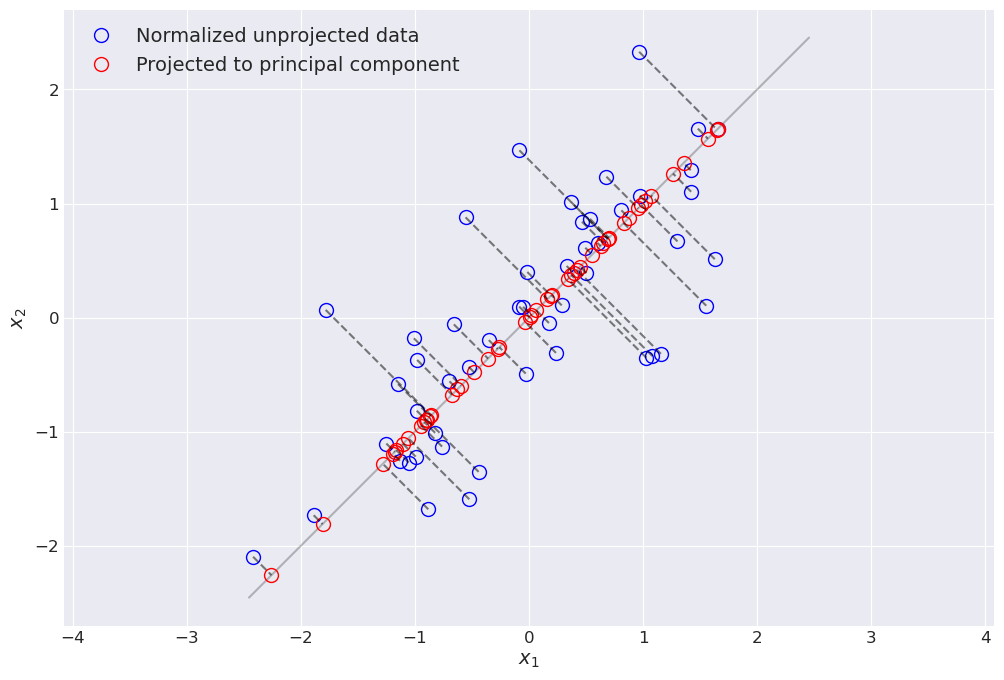

In [63]:
# plot the raw data again, we are displaying the raw data after normalization now, because the projected data 
# will be back into this normalized space
m, n = X_rec.shape
plt.figure()
plt.plot(X_norm[:, 0], X_norm[:, 1], 'bo', markersize=10, fillstyle='none', label='Normalized unprojected data')
plt.axis('equal')
ax = plt.gca()

# plot principal component 1.  u1 is a vector, we will plot this vector from the mu means of our data
v = u1 * 2.0 * S[0] # multiplying by S has effect of scaling this component by the magnitude of variance
plt.plot([ 0,  v[0] ], [ 0,  v[1] ], 'k-', alpha=0.25)
plt.plot([ 0, -v[0] ], [ 0, -v[1] ], 'k-', alpha=0.25)

# plot the recovered data as red circles
plt.plot(X_rec[:, 0], X_rec[:, 1], 'ro', markersize=10, fillstyle='none', label='Projected to principal component')

# connect each original point with the recovered/projected point
for i in range(m):
    p_norm = X_norm[i, :]
    p_rec = X_rec[i, :]
    plt.plot([p_norm[0], p_rec[0]], [p_norm[1], p_rec[1]], 'k--', alpha=0.5)

plt.xlabel(f'$x_1$')
plt.ylabel(f'$x_2$')
plt.legend();